In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import gc
from pathlib import Path


from sklearn.metrics import accuracy_score
from IPython.display import FileLink

In [151]:
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision.models import *

In [ ]:
DATA_DIR = Path('../input')

In [ ]:
train_df = pd.read_csv(DATA_DIR/'train.csv')
test_df = pd.read_csv(DATA_DIR/'test.csv')

In [ ]:
label_mapper = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}

In [ ]:
train_df['label'] = train_df['label'].map(label_mapper)

In [ ]:
train_df.head()

In [ ]:
def get_ex(path): return open_image(path)

def plots_f(path, tfms, rows, cols, width, height, **kwargs):
    [get_ex(path).apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(rows,cols,figsize=(width,height))[1].flatten())]

In [ ]:
tfms = get_transforms(xtra_tfms=[cutout(n_holes=(1,4), length=(10, 20), p=.75), jitter(magnitude=0.005, p=.25)])
len(tfms)

In [ ]:
open_image(DATA_DIR/'images/images/7238.jpg').show()

In [ ]:
plots_f(DATA_DIR/'images/images/7238.jpg', tfms, 2, 4, 12, 6, size=150)

In [ ]:
train_il = ImageList.from_df(df=train_df, cols='image_name', path=DATA_DIR/'images/images')
test_il = ImageList.from_df(df=test_df, cols='image_name', path=DATA_DIR/'images/images')

In [ ]:
np.random.seed(0)
src1 = (train_il
        .split_from_df(col='valid')
        .label_from_df(cols='label')
        .add_test(test_il))

In [ ]:
tfms = get_transforms(xtra_tfms=[cutout(n_holes=(1,4), length=(10, 20), p=.75)])
data1 = (src1
        .transform(tfms, size=75)
        .databunch(path='.', bs=128, num_workers=0)
        .normalize([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])) # use normalization of places model

In [ ]:
data1

In [ ]:
data1.show_batch()

In [ ]:
# th architecture to use
arch = 'resnet50'

# load the pre-trained weights
model_file = '%s_places365.pth.tar' % arch
if not os.access(model_file, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_file
    os.system('wget ' + weight_url)

In [ ]:
!ls

In [ ]:
def places_resnet50(f=None):
    import torchvision.models as models
    model = models.__dict__['resnet50'](num_classes=365)
    checkpoint = torch.load('resnet50_places365.pth.tar', map_location=lambda storage, loc: storage)
    state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
    model.eval()
    return model

def getLearner(data):
    learn1 = cnn_learner(data, places_resnet50, metrics=[accuracy])
#     learn_g1 = learn1.layer_groups[0][0:57]
#     learn_g2 = learn1.layer_groups[0][57:]
#     learn_g3 = learn1.layer_groups[1]
#     learn1.layer_groups[0] = learn_g1
#     learn1.layer_groups[1] = learn_g2
#     learn1.layer_groups.append(learn_g3)
    return learn1

In [ ]:
learn1 = getLearner(data1)

In [ ]:
len(learn1.layer_groups)

In [ ]:
learn1.wd

In [ ]:
learn1.lr_find()

In [ ]:
learn1.recorder.plot()

In [ ]:
rn50_places_stage1_callbacks = [CSVLogger(learn=learn1, filename='rn50-places-stage1-history'), ShowGraph(learn=learn1)]

In [ ]:
lr = 1e-2
learn1.fit_one_cycle(5, slice(lr), callbacks=rn50_places_stage1_callbacks)

<pre>
epoch  train_loss  valid_loss  accuracy  time
0	0.578454	0.327260	0.886997	01:10
1	0.424681	0.300474	0.899912	01:10
2	0.345923	0.235558	0.915468	01:09
3	0.282433	0.219068	0.923393	01:10
4	0.254160	0.213134	0.926915	01:11
</pre>

In [ ]:
learn1.save('rn50-places-stage1')

In [148]:
learn1.unfreeze()

In [ ]:
learn1.lr_find()

In [ ]:
learn1.recorder.plot()

In [ ]:
# rn101_stage2_callbacks = [CSVLogger(learn=learn1, filename='rn101-stage2-history'), EarlyStoppingCallback(learn=learn1, monitor='accuracy', min_delta=0.005, patience=8), SaveModelCallback(learn=learn1, monitor='accuracy', name='rn101-stage2'), ShowGraph(learn=learn1)]     

In [ ]:
rn50_places_stage2_callbacks = [CSVLogger(learn=learn1, filename='rn50-places-stage2-history'),ShowGraph(learn=learn1)]

epoch,train_loss,valid_loss,accuracy,time
0,0.248155,0.233916,0.914001,01:14
1,0.244812,0.240787,0.914881,01:13
2,0.202341,0.214860,0.930731,01:14
3,0.157789,0.210862,0.928970,01:13
4,0.120363,0.211528,0.930731,01:16


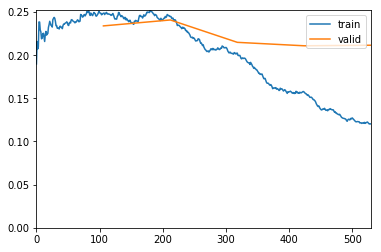

In [149]:
learn1.fit_one_cycle(5, slice(1e-4, lr/5), callbacks=rn50_places_stage2_callbacks)

<pre>
epoch  train_loss  valid_loss  accuracy  time
0	0.248155	0.233916	0.914001	01:14
1	0.244812	0.240787	0.914881	01:13
2	0.202341	0.214860	0.930731	01:14
3	0.157789	0.210862	0.928970	01:13
4	0.120363	0.211528	0.930731	01:16
</pre>

In [150]:
learn1.save('rn50-places-stage2')

In [155]:
from fastai.callbacks.hooks import *
import cv2
import matplotlib.pyplot as plt
import random

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index, learner, imgDataBunch):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImg,cl = imgDataBunch.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = imgDataBunch.one_item(tensorImg)
    oneBatch_im = vision.Image(imgDataBunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm

# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, learner, imgDataBunch, classes=['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = random.randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx, learner, imgDataBunch)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

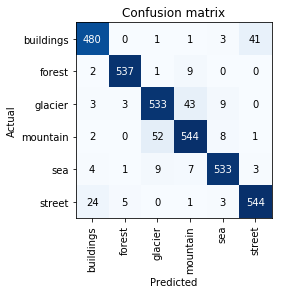

In [153]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix(title='Confusion matrix')

Almost all the problem is with mountain and glacier, street and building.

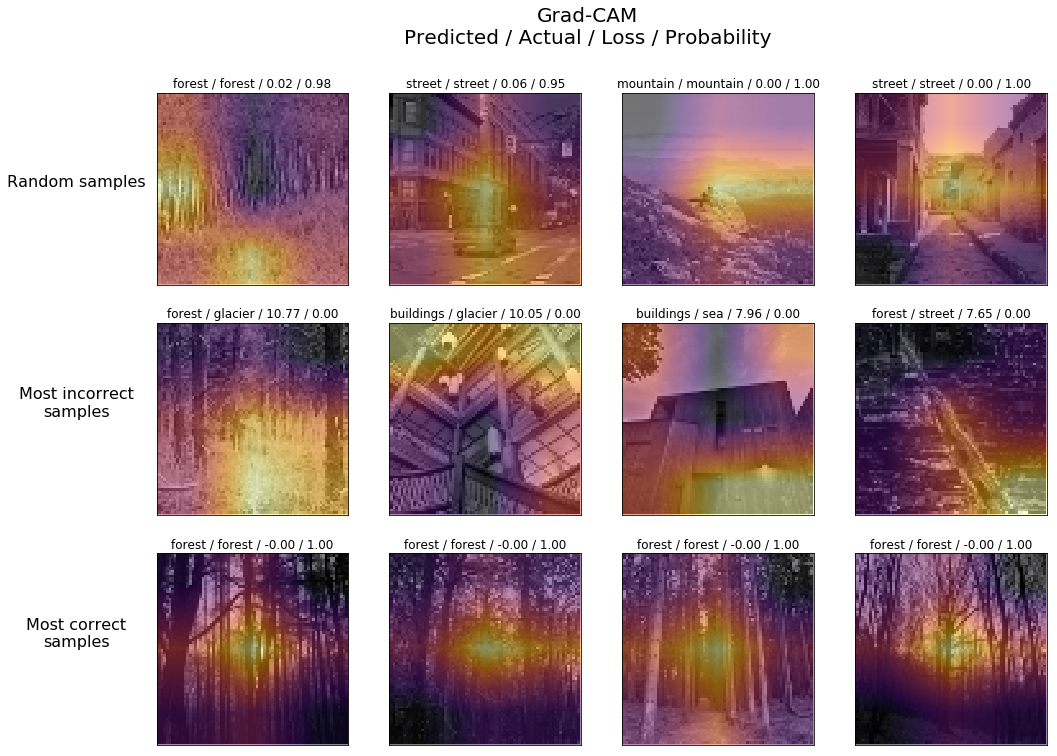

In [156]:
plot_heatmap_overview(interp, learn1, data1)

In [157]:
data2 = (src1
        .transform(tfms, size=150)
        .databunch(path='.', bs=128, num_workers=0)
        .normalize([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])) # use normalization of places model

In [158]:
learn1.data = data2

In [159]:
learn1.freeze()

In [160]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


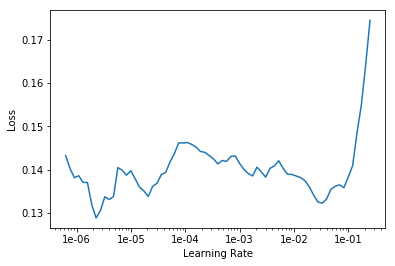

In [161]:
learn1.recorder.plot()

In [162]:
rn50_places_im150_stage1_callbacks = [CSVLogger(learn=learn1, filename='rn50-places-im150-stage1-history'), ShowGraph(learn=learn1)]

epoch,train_loss,valid_loss,accuracy,time
0,0.149312,0.175462,0.944820,01:59
1,0.146114,0.194937,0.942178,01:56
2,0.131685,0.163045,0.950983,01:53
3,0.104412,0.166025,0.952451,01:53
4,0.092323,0.165978,0.953331,01:53


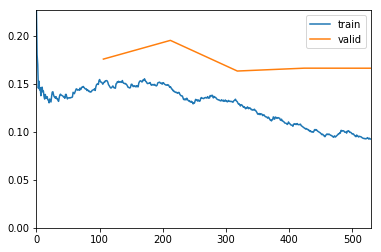

In [163]:
lr = 8e-3
learn1.fit_one_cycle(5, slice(lr), callbacks=rn50_places_im150_stage1_callbacks)

<pre>
epoch  train_loss  valid_loss  accuracy  time
0	0.149312	0.175462	0.944820	01:59
1	0.146114	0.194937	0.942178	01:56
2	0.131685	0.163045	0.950983	01:53
3	0.104412	0.166025	0.952451	01:53
4	0.092323	0.165978	0.953331	01:53
</pre>

In [164]:
learn1.save('rn50-places-im150-stage1')

In [165]:
learn1.unfreeze()
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


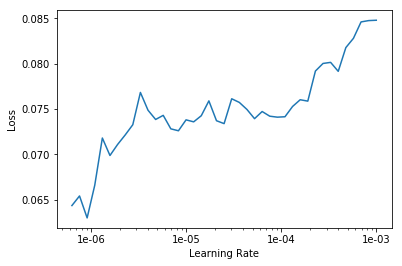

In [166]:
learn1.recorder.plot()

In [167]:
rn50_places_im150_stage2_callbacks = [CSVLogger(learn=learn1, filename='rn50-places-im150-stage2-history'), ShowGraph(learn=learn1)]

epoch,train_loss,valid_loss,accuracy,time
0,0.083343,0.168809,0.952451,02:06
1,0.082456,0.179389,0.948635,02:04
2,0.076066,0.184753,0.949809,02:03
3,0.063677,0.185414,0.948048,02:04
4,0.060283,0.189579,0.949222,02:04


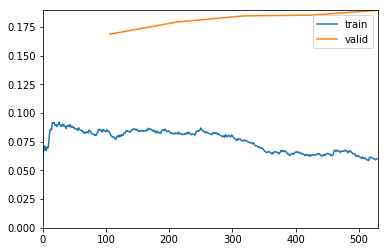

In [169]:
learn1.fit_one_cycle(5, slice(1e-5, lr/5), callbacks=rn50_places_im150_stage2_callbacks)

In [170]:
# accuracy didn't improve revert back to stage 1
learn1.load('rn50-places-im150-stage1');
learn1.freeze()

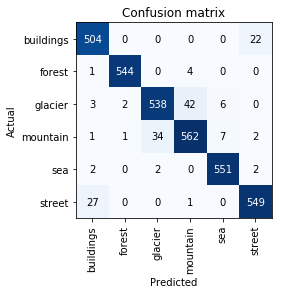

In [171]:
interp = ClassificationInterpretation.from_learner(learn1)
interp.plot_confusion_matrix(title='Confusion matrix')

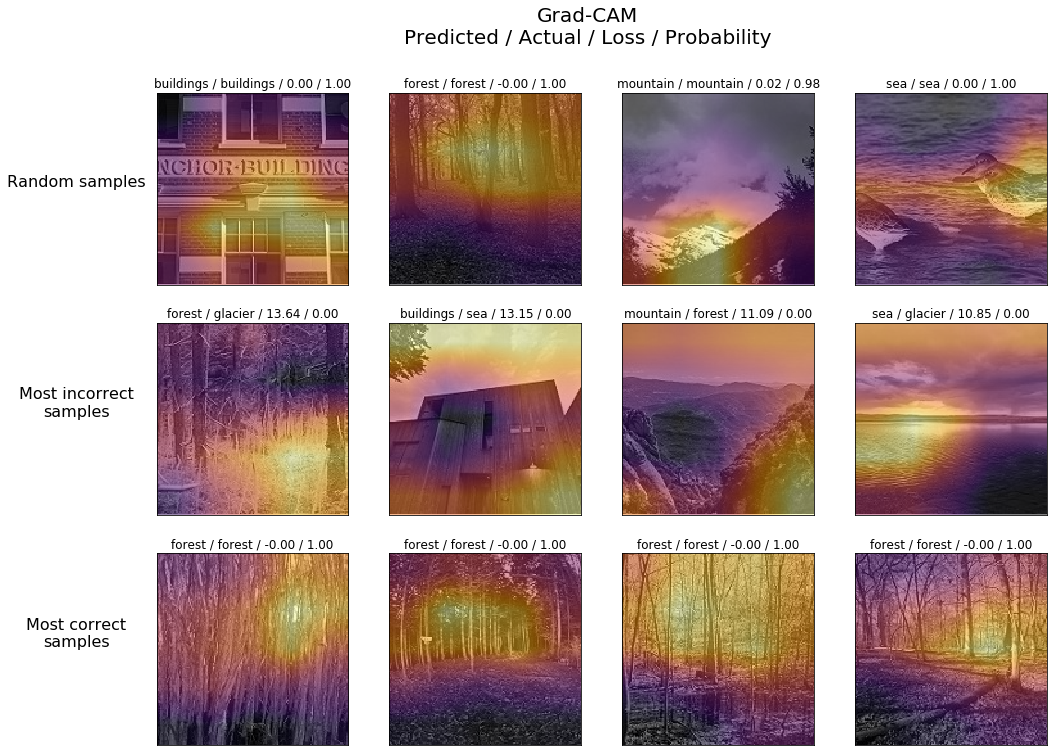

In [172]:
plot_heatmap_overview(interp, learn1, data2)

In [173]:
val_preds_tta = learn1.TTA(ds_type=DatasetType.Valid)

In [174]:
accuracy_score(y_pred=val_preds_tta[0].argmax(1).numpy(), y_true=val_preds_tta[1].numpy())

0.9506897563839155

In [175]:
val_preds = learn1.get_preds()

In [181]:
accuracy_score(y_pred=val_preds[0].argmax(1).numpy(), y_true=val_preds[1].numpy())

0.9533313765776343

In [182]:
val_img_names = [Path(i).name for i in learn1.data.valid_ds.x.items]

In [183]:
val_probs_tta_df = pd.DataFrame(val_preds_tta[0].numpy(), columns=learn1.data.train_ds.classes)
val_probs_tta_df['image_name'] = val_img_names
val_probs_tta_df['ground_label'] = val_preds_tta[1].numpy()

In [184]:
val_probs_df = pd.DataFrame(val_preds[0].numpy(), columns=learn1.data.train_ds.classes)
val_probs_df['image_name'] = val_img_names
val_probs_df['ground_label'] = val_preds[1].numpy()

In [180]:
test_preds_tta = learn1.TTA(ds_type=DatasetType.Test)

In [185]:
test_preds = learn1.get_preds(ds_type=DatasetType.Test)

In [186]:
test_img_names = [Path(i).name for i in learn1.data.test_ds.x.items]

In [187]:
test_probs_tta_df = pd.DataFrame(test_preds_tta[0].numpy(), columns=learn1.data.train_ds.classes)
test_probs_tta_df['image_name'] = test_img_names

In [188]:
test_probs_df = pd.DataFrame(test_preds[0].numpy(), columns=learn1.data.train_ds.classes)
test_probs_df['image_name'] = test_img_names

In [189]:
test_pred_tta_df = pd.DataFrame({'image_name': test_img_names})
test_pred_tta_df['label'] = test_preds_tta[0].argmax(1).numpy()

In [190]:
test_pred_df = pd.DataFrame({'image_name': test_img_names})
test_pred_df['label'] = test_preds[0].argmax(1).numpy()

In [191]:
val_probs_tta_df.to_csv('val_probs_tta.csv', index=False)
val_probs_df.to_csv('val_probs.csv', index=False)
test_probs_tta_df.to_csv('test_probs_tta.csv', index=False)
test_probs_df.to_csv('test_probs.csv', index=False)
test_pred_tta_df.to_csv('test_pred_tta.csv', index=False)
test_pred_df.to_csv('test_pred.csv', index=False)

In [192]:
!ls

__notebook_source__.ipynb	      test_pred.csv
models				      test_pred_tta.csv
resnet50_places365.pth.tar	      test_probs.csv
rn50-places-im150-stage1-history.csv  test_probs_tta.csv
rn50-places-im150-stage2-history.csv  val_probs.csv
rn50-places-stage1-history.csv	      val_probs_tta.csv
rn50-places-stage2-history.csv


In [193]:
!ls -lh models

total 622M
-rw-r--r-- 1 root root 115M Mar 31 14:33 rn50-places-im150-stage1.pth
-rw-r--r-- 1 root root 115M Mar 31 13:48 rn50-places-stage1.pth
-rw-r--r-- 1 root root 294M Mar 31 14:09 rn50-places-stage2.pth
-rw-r--r-- 1 root root  99M Mar 31 14:34 tmp.pth


In [194]:
FileLink('val_probs_tta.csv')

/kaggle/working/val_probs_tta.csv

In [195]:
FileLink('val_probs.csv')

/kaggle/working/val_probs.csv

In [196]:
FileLink('test_probs_tta.csv')

/kaggle/working/test_probs_tta.csv

In [197]:
FileLink('test_probs.csv')

/kaggle/working/test_probs.csv

In [198]:
FileLink('test_pred_tta.csv')

/kaggle/working/test_pred_tta.csv

In [199]:
FileLink('test_pred.csv')

/kaggle/working/test_pred.csv

In [201]:
FileLink('rn50-places-stage1-history.csv')

/kaggle/working/rn50-places-stage1-history.csv

In [202]:
FileLink('rn50-places-stage2-history.csv')

/kaggle/working/rn50-places-stage2-history.csv

In [203]:
FileLink('rn50-places-im150-stage1-history.csv')

/kaggle/working/rn50-places-im150-stage1-history.csv

In [ ]:
#FileLink('rn50-im150-stage2-history.csv')